In [36]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import math
from pathlib import Path
import random

## Visualization

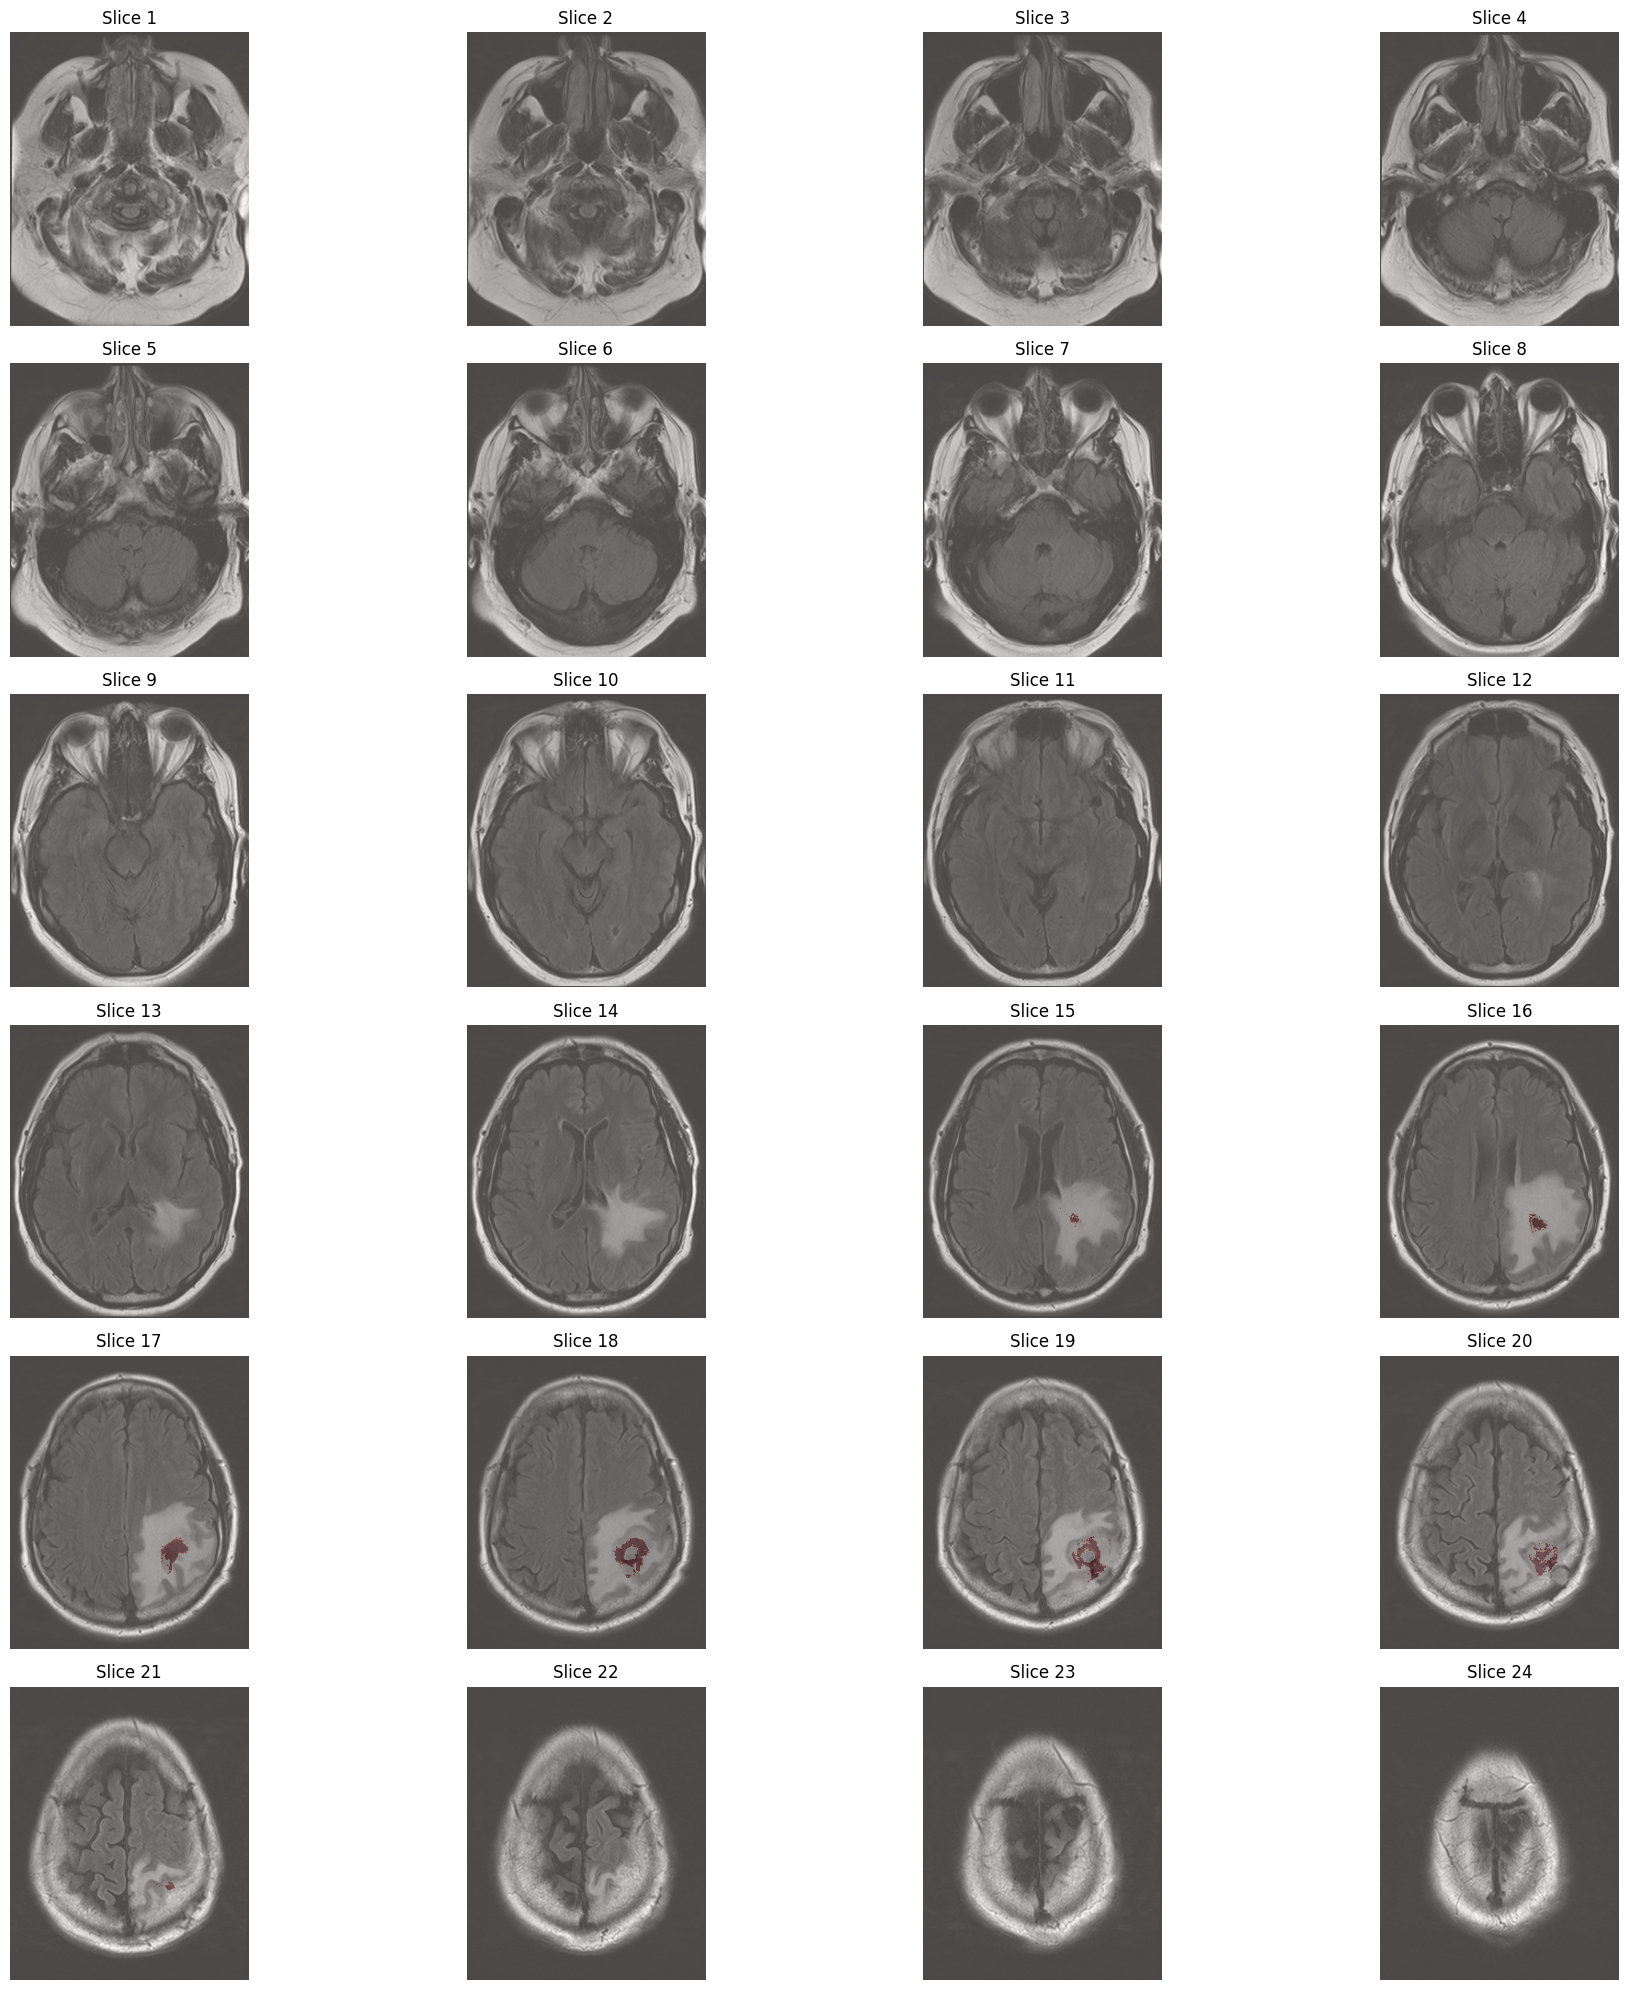

In [ ]:
# ===== CONFIG =====
BASE_PATH = "Tumor_Data/Brain-Tumor-Progression/PGBM-001/FH HEADBrain Protocols"
T1_DIR = os.path.join(BASE_PATH, "FLAIRreg")
MASK_DIR = os.path.join(BASE_PATH, "MaskTumor")

# ===== LIST FILES =====
t1_files = sorted([os.path.join(T1_DIR, f) for f in os.listdir(T1_DIR) if f.endswith(".dcm")])
mask_files = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR) if f.endswith(".dcm")])

# ===== LOAD ALL =====
def load_dicom(path):
    return pydicom.dcmread(path).pixel_array

t1_images = [load_dicom(f) for f in t1_files[:24]]   # first 20 slices
mask_images = [load_dicom(f) for f in mask_files[:24]]

# ===== PLOT =====
fig, axs = plt.subplots(6, 4, figsize=(20, 20))  # 4 rows × 5 cols = 20
axs = axs.flatten()

for i in range(24):
    axs[i].imshow(t1_images[i], cmap='gray')
    axs[i].imshow(mask_images[i], cmap='Reds', alpha=0.3)  # overlay mask
    axs[i].set_title(f"Slice {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

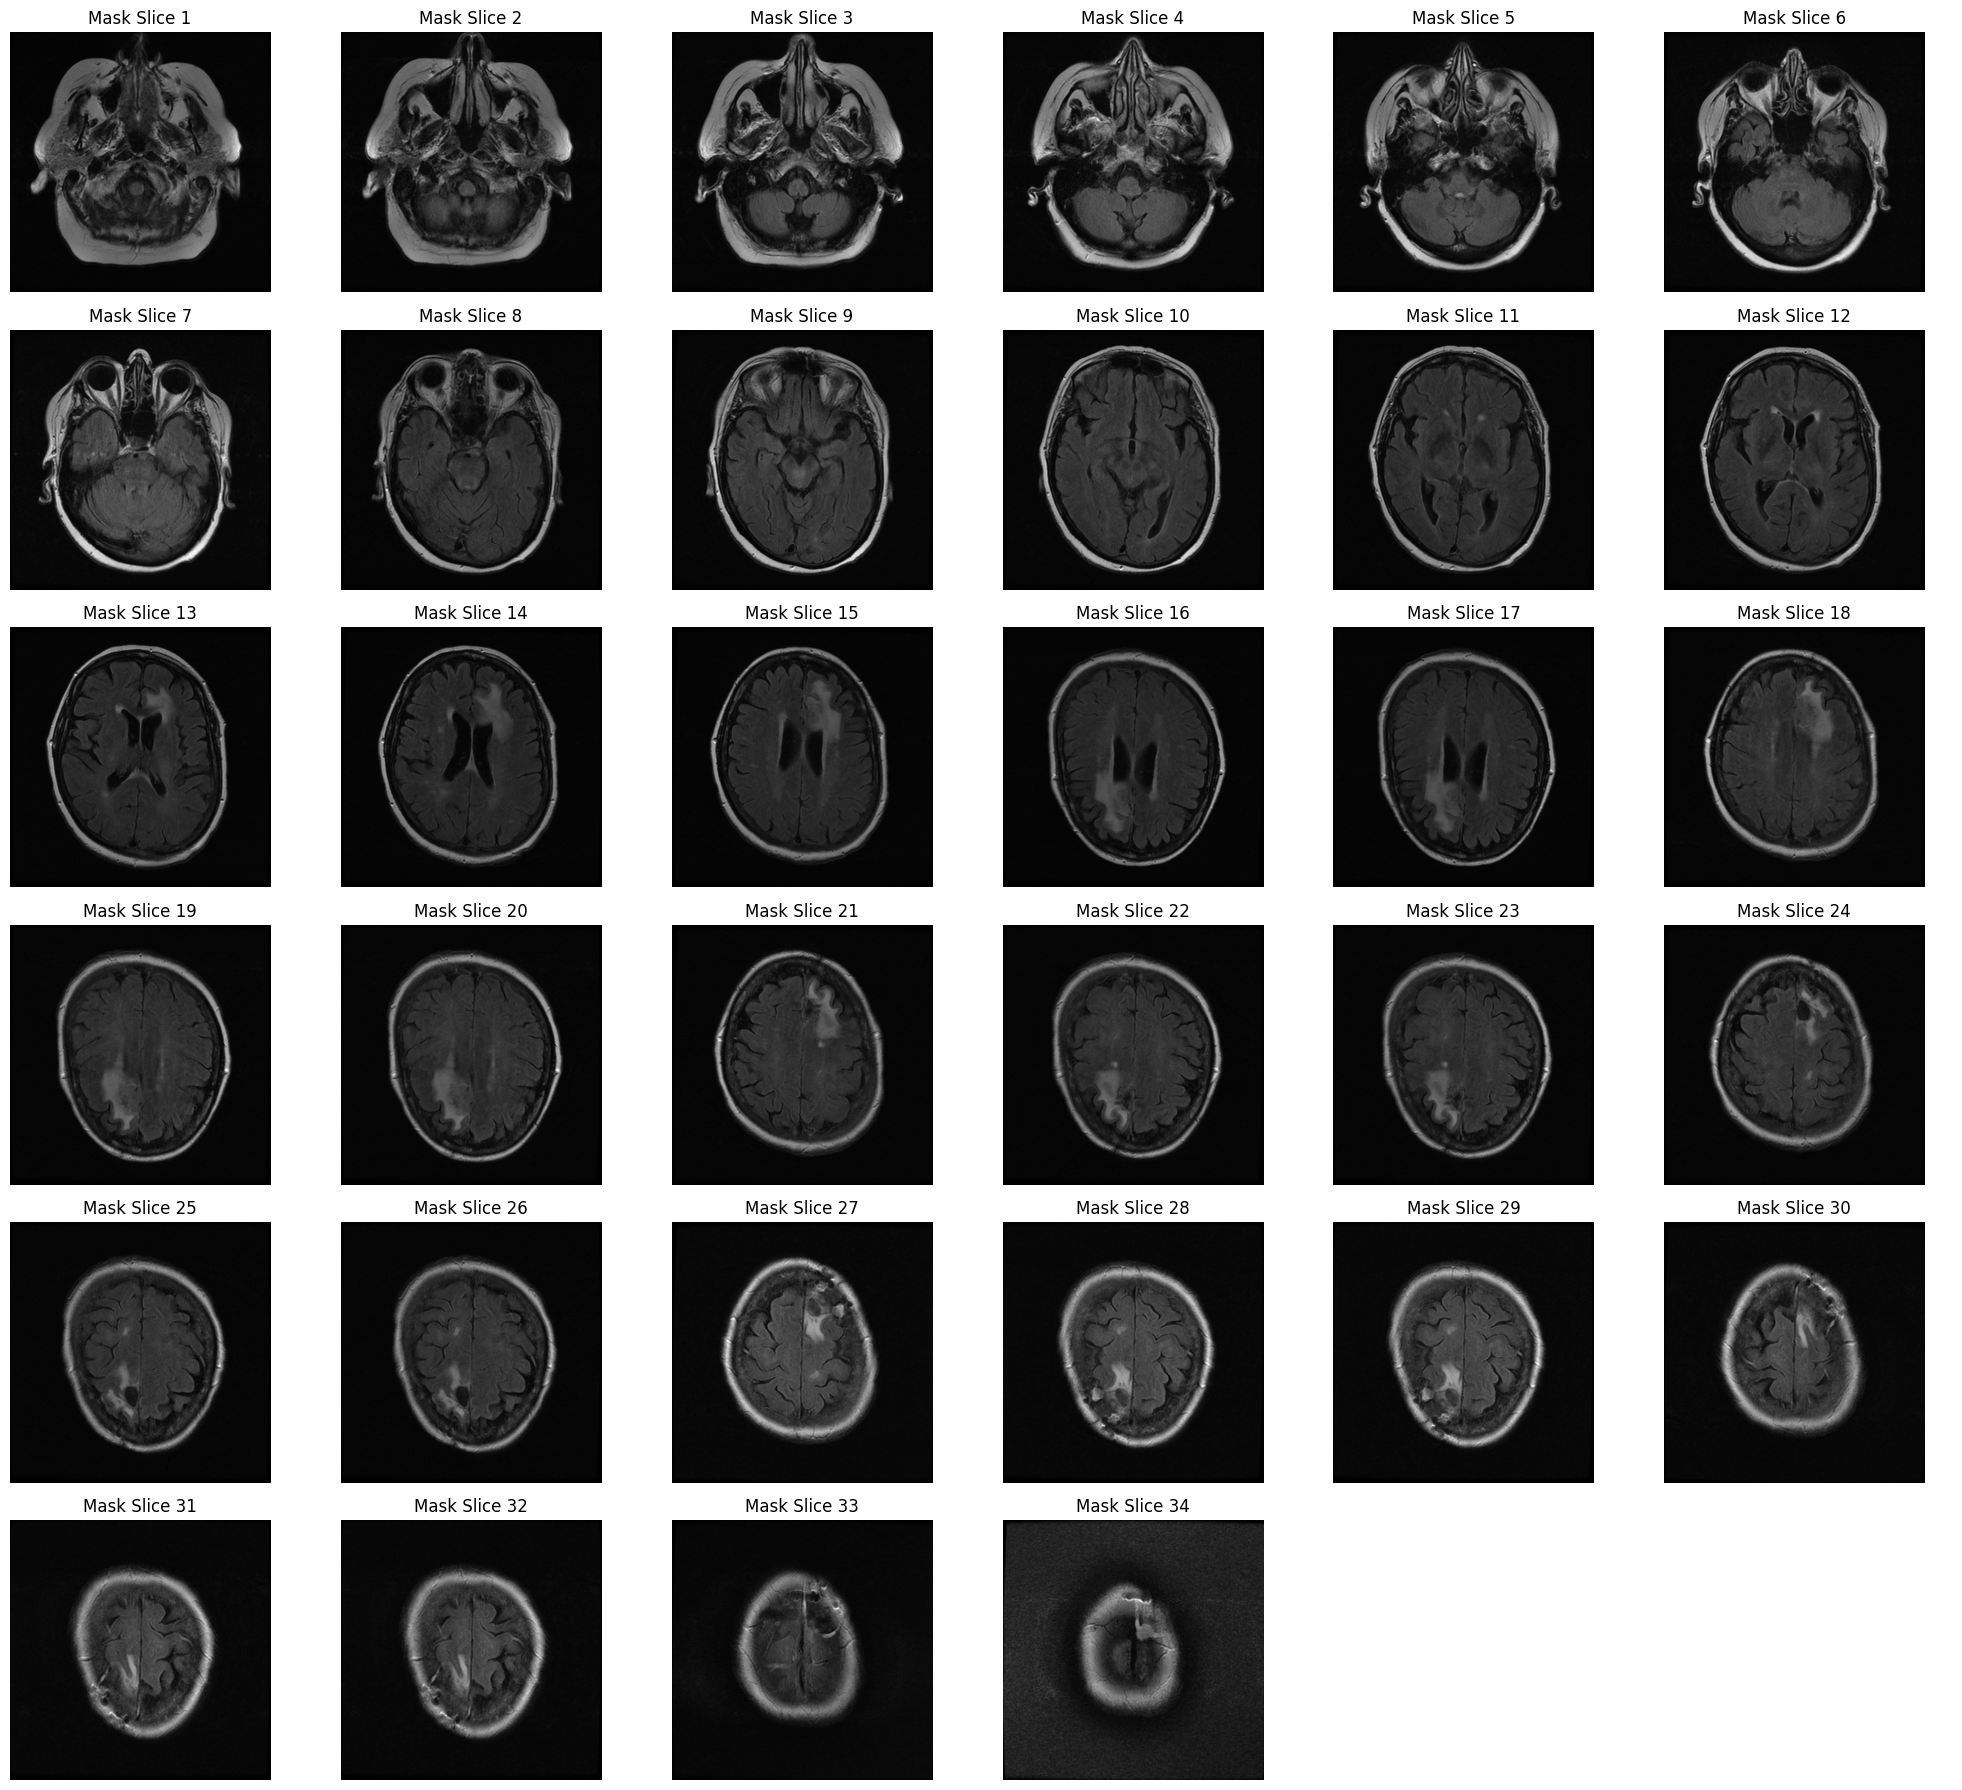

In [51]:
# ===== CONFIG =====
BASE_PATH = "Tumor_Data/Brain-Tumor-Progression/PGBM-007/Mr Rcbv Sequence Fh"
MASK_DIR = os.path.join(BASE_PATH, "FLAIRreg")

# ===== LIST FILES =====
mask_files = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR) if f.endswith(".dcm")])

# ===== LOAD ALL =====
def load_dicom(path):
    return pydicom.dcmread(path).pixel_array

mask_images = [load_dicom(f) for f in mask_files]

# ===== PLOT =====
n_images = len(mask_images)
cols = 6  # number of columns in grid
rows = math.ceil(n_images / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 3))
axs = axs.flatten()

for i, img in enumerate(mask_images):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Mask Slice {i+1}")
    axs[i].axis('off')

# Hide empty subplots if total images not perfectly divisible by cols
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


## Data Oversampling

In [42]:
# ===== CONFIG =====
BASE_PATH = "Tumor_Data/Brain-Tumor-Progression"  # path containing all PGBM-001 ... PGBM-020

# ===== FUNCTION TO CHECK MASK =====
def has_tumor(dcm_path):
    arr = pydicom.dcmread(dcm_path).pixel_array
    return np.any(arr > 0)  # True if tumor pixels present

# ===== MAIN LOOP =====
total_masks = 0
non_tumor_count= 0
tumor_count = 0

# Loop over PGBM patient folders
for patient in sorted(os.listdir(BASE_PATH)):
    patient_path = os.path.join(BASE_PATH, patient)
    if not os.path.isdir(patient_path):
        continue

    # Each patient has 2 scan subfolders
    for scan_folder in os.listdir(patient_path):
        scan_path = os.path.join(patient_path, scan_folder)
        mask_dir = os.path.join(scan_path, "MaskTumor")
        
        if not os.path.isdir(mask_dir):
            continue
        
        # Iterate through mask files
        for mask_file in os.listdir(mask_dir):
            if mask_file.endswith(".dcm"):
                total_masks += 1
                if has_tumor(os.path.join(mask_dir, mask_file)):
                    tumor_count += 1
                else:
                    non_tumor_count += 1

print(f"Total mask images: {total_masks}")
print(f"Images with tumor: {tumor_count}")
print(f"Images without tumor (fully black): {non_tumor_count}")


Total mask images: 918
Images with tumor: 283
Images without tumor (fully black): 635


In [33]:
print(f"Total mask images: {total_masks}")
print(f"Images with tumor: {tumor_count}")
print(f"Images without tumor (fully black): {non_tumor_count}")

Total mask images: 918
Images with tumor: 283
Images without tumor (fully black): 635


In [48]:
BASE_PATH = "Tumor_Data/Brain-Tumor-Progression"
MODALITIES = ["T1post", "MaskTumor", "FLAIRreg", "T2reg"]

def load_dicom(path):
    return pydicom.dcmread(path)

def save_dicom(ds, pixel_array, out_path):
    ds.PixelData = pixel_array.tobytes()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    ds.save_as(str(out_path))

def is_tumor(mask_array):
    return np.any(mask_array > 0)

pgbm_folders = [f for f in os.listdir(BASE_PATH) if f.startswith("PGBM")]

for pgbm in pgbm_folders:
    pgbm_path = os.path.join(BASE_PATH, pgbm)
    subfolders = [os.path.join(pgbm_path, sf) for sf in os.listdir(pgbm_path)]
    
    for subfolder in subfolders:
        mask_dir = os.path.join(subfolder, "MaskTumor")
        if not os.path.exists(mask_dir):
            continue
        
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".dcm")])
        
        for fname in mask_files:
            mask_path = os.path.join(mask_dir, fname)
            mask_ds = load_dicom(mask_path)
            mask_img = mask_ds.pixel_array
            
            if is_tumor(mask_img):
                for copy_num in range(1, 3):  # create 2 extra copies
                    for modality in MODALITIES:
                        file_path = os.path.join(subfolder, modality, fname)
                        if not os.path.exists(file_path):
                            continue
                        ds = load_dicom(file_path)
                        img = ds.pixel_array
                        rotated = np.rot90(img, 2)  # 180 degrees
                        
                        new_name = fname.replace(".dcm", f"_rot180copy{copy_num}.dcm")
                        out_path = Path(subfolder) / modality / new_name
                        save_dicom(ds, rotated, out_path)

print("✅ Tumor oversampling with 180° rotation complete!")


✅ Tumor oversampling with 180° rotation complete!


In [49]:
# ===== CONFIG =====
BASE_PATH = "Tumor_Data/Brain-Tumor-Progression"  # path containing all PGBM-001 ... PGBM-020

# ===== FUNCTION TO CHECK MASK =====
def has_tumor(dcm_path):
    arr = pydicom.dcmread(dcm_path).pixel_array
    return np.any(arr > 0)  # True if tumor pixels present

# ===== MAIN LOOP =====
total_masks_2 = 0
non_tumor_count_2 = 0
tumor_count_2 = 0

# Loop over PGBM patient folders
for patient in sorted(os.listdir(BASE_PATH)):
    patient_path = os.path.join(BASE_PATH, patient)
    if not os.path.isdir(patient_path):
        continue

    # Each patient has 2 scan subfolders
    for scan_folder in os.listdir(patient_path):
        scan_path = os.path.join(patient_path, scan_folder)
        mask_dir = os.path.join(scan_path, "MaskTumor")
        
        if not os.path.isdir(mask_dir):
            continue
        
        # Iterate through mask files
        for mask_file in os.listdir(mask_dir):
            if mask_file.endswith(".dcm"):
                total_masks_2 += 1
                if has_tumor(os.path.join(mask_dir, mask_file)):
                    tumor_count_2 += 1
                else:
                    non_tumor_count_2 += 1

print(f"Total mask images: {total_masks_2}")
print(f"Images with tumor: {tumor_count_2}")
print(f"Images without tumor (fully black): {non_tumor_count_2}")


Total mask images: 1484
Images with tumor: 849
Images without tumor (fully black): 635
